In [1]:
import pandas as pd
from pandas import * 
import os   
import sys 
import numpy as np
import fileinput
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt 

from pylab import *

import matplotlib.ticker as tkr 
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import pandas.io.sql
import pyodbc 
from datetime import datetime
from textwrap import wrap

import EAtools as ea
import heapq

ea.set_options()
ea.ea_report_style()
ea_p=ea.ea_p
ea_s=ea.ea_s
def cm2inch(value):
    return value/2.54
ea.set_options()
ea.ea_report_style()
%pylab inline
%matplotlib inline
from datetime import date, datetime, time, timedelta
from db import DB

#from Tkinter import *

def point2inch(value):
    return value/72

path='/media/usb/notebooks/Roger/pivot/'
#path2='media/usb/notebooks/Juliaa/Market competition review/'
db = DB(profile="hallj")

Populating the interactive namespace from numpy and matplotlib


/home/julia/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'linalg', 'datetime', 'fft', 'power', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Process Island gross MW results

In [2]:
pivot = pd.read_csv('/media/usb/notebooks/Roger/pivot/pivot_MW_201501_202012.csv')
pivot2 = pd.read_csv('/media/usb/notebooks/Roger/pivot/pivot_MW_202101_202106.csv')
pivot = pivot.append(pivot2,sort=False)
pivot.tail()

,party_code,interval,island,scenario,traderGenMW,traderMinMW,traderPivotMW,rm_MW,hedge_MW,vas_MW,ftr_MW,wind_MW
104275,MRPL,31-MAY-2021 22:30,SI,MRPL_NI,0.0,0,0.0,-79.258,50.75,68.4,62.3,NaN
104276,MRPL,31-MAY-2021 23:00,NI,MRPL_NI,93.0,93,0.0,-456.204,-32.62,-68.4,61.6,NaN
104277,MRPL,31-MAY-2021 23:00,SI,MRPL_NI,0.0,0,0.0,-77.626,50.75,68.4,62.3,NaN
104278,MRPL,31-MAY-2021 23:30,NI,MRPL_NI,93.0,93,0.0,-426.768,-32.62,-68.4,61.6,NaN
104279,MRPL,31-MAY-2021 23:30,SI,MRPL_NI,0.0,0,0.0,-76.330,50.75,68.4,62.3,NaN


In [3]:
pivot.rename(columns={'interval':'DateTime','island':'Island','scenario':'Scenario'},inplace=True)
pivot['DateTime']=pd.to_datetime(pivot.DateTime.str.replace(';00', ':40', regex=False)\
                                 .str.replace(';30', ':50', regex=False)\
                                 , errors='raise', format='%d-%b-%Y %H:%M') #deal with daylight saving strings
pivot['year'] = pivot['DateTime'].dt.year
pivot['month'] = pivot['DateTime'].dt.month
pivot['day'] = pivot['DateTime'].dt.day
#mask = (pivot.DateTime  <= '09-11-2019') | (pivot.DateTime  > '28-03-2020')
mask = pivot.month < 13
pivot = pivot.loc[mask]
pivot.tail()

,party_code,DateTime,Island,Scenario,traderGenMW,traderMinMW,traderPivotMW,rm_MW,hedge_MW,vas_MW,ftr_MW,wind_MW,year,month,day
104275,MRPL,2021-05-31 22:30:00,SI,MRPL_NI,0.0,0,0.0,-79.258,50.75,68.4,62.3,NaN,2021,5,31
104276,MRPL,2021-05-31 23:00:00,NI,MRPL_NI,93.0,93,0.0,-456.204,-32.62,-68.4,61.6,NaN,2021,5,31
104277,MRPL,2021-05-31 23:00:00,SI,MRPL_NI,0.0,0,0.0,-77.626,50.75,68.4,62.3,NaN,2021,5,31
104278,MRPL,2021-05-31 23:30:00,NI,MRPL_NI,93.0,93,0.0,-426.768,-32.62,-68.4,61.6,NaN,2021,5,31
104279,MRPL,2021-05-31 23:30:00,SI,MRPL_NI,0.0,0,0.0,-76.330,50.75,68.4,62.3,NaN,2021,5,31


In [4]:
pivot.set_index(['year','month','day','DateTime','Island','Scenario'],inplace=True)
pivot=pivot.iloc[pivot.index.map(lambda x: (x[0] in [2015,2016,2017,2018,2019,2020,2021]))]
#pivot.sort_index(inplace=True)
pivot.head()

party_code  traderGenMW  traderMinMW  traderPivotMW    rm_MW  hedge_MW  vas_MW  ftr_MW  wind_MW
year month day DateTime   Island Scenario                                                                                                
2015 4     1   2015-04-01 NI     CTCT_NI        CTCT          0.0            0            0.0 -530.186   -235.11     0.0   219.8      0.0
                                 CTCT_SI        CTCT          0.0            0            0.0 -530.186   -235.11     0.0   219.8      0.0
                                 CTCT_NZ        CTCT          0.0            0            0.0 -530.186   -235.11     0.0   219.8      0.0
                          SI     CTCT_NI        CTCT          0.0            0            0.0 -284.050    -96.21     0.0   126.3      0.0
                                 CTCT_SI        CTCT        185.0          185            0.0 -284.050    -96.21     0.0   126.3      0.0

In [5]:
pivot.tail()

party_code  traderGenMW  traderMinMW  traderPivotMW    rm_MW  hedge_MW  vas_MW  ftr_MW  wind_MW
year month day DateTime            Island Scenario                                                                                                
2021 5     31  2021-05-31 22:30:00 SI     MRPL_NI        MRPL          0.0            0            0.0  -79.258     50.75    68.4    62.3      NaN
               2021-05-31 23:00:00 NI     MRPL_NI        MRPL         93.0           93            0.0 -456.204    -32.62   -68.4    61.6      NaN
                                   SI     MRPL_NI        MRPL          0.0            0            0.0  -77.626     50.75    68.4    62.3      NaN
               2021-05-31 23:30:00 NI     MRPL_NI        MRPL         93.0           93            0.0 -426.768    -32.62   -68.4    61.6      NaN
                                   SI     MRPL_NI        MRPL          0.0            0            0.0  -76.330     50.75    68.4    62.3      NaN

In [6]:
pivot=pivot.groupby(level=[0,1,2,3,4,5]).first() #remove duplicates

In [7]:
pivot['grossPivotal']=pivot.traderPivotMW.apply(lambda x: x>0)

In [8]:
pivot.head()

party_code  traderGenMW  traderMinMW  traderPivotMW    rm_MW  hedge_MW  vas_MW  ftr_MW  wind_MW  grossPivotal
year month day DateTime   Island Scenario                                                                                                              
2015 1     1   2015-01-01 NI     CTCT_NI        CTCT          0.0            0            0.0 -478.462   -120.21     0.0   215.4    0.000         False
                                 CTCT_NZ        CTCT          0.0            0            0.0 -478.462   -120.21     0.0   215.4    0.000         False
                                 CTCT_SI        CTCT          0.0            0            0.0 -478.462   -120.21     0.0   215.4    0.000         False
                                 GENE_NI        GENE          0.0            0            0.0 -321.324    -69.08   -51.3     0.0    0.000         False
                                 MERI_SI        MERI          0.0            0            0.0 -295.384   -120.14   131.1    64.1  263.938         False

In [9]:
pivot.tail()

party_code  traderGenMW  traderMinMW  traderPivotMW    rm_MW  hedge_MW  vas_MW  ftr_MW  wind_MW  grossPivotal
year month day DateTime            Island Scenario                                                                                                              
2021 6     30  2021-06-30 23:30:00 SI     CTCT_NZ        CTCT        0.000            0          0.000 -243.880   -170.36     0.0    92.2      NaN         False
                                          CTCT_SI        CTCT        0.000            0          0.000 -243.880   -170.36     0.0    92.2      NaN         False
                                          GENE_NI        GENE        0.000            0          0.000 -181.428    -71.79    51.3    96.9      NaN         False
                                          MERI_SI        MERI      323.095           15        308.095 -901.294   -134.75  -119.7    82.2      NaN          True
                                          MRPL_NI        MRPL        0.000            0          0.000  -83.446     91.75    68.4    53.1      NaN         False

In [10]:
pivot = pivot.reset_index()
#pivot = pivot[pivot.DateTime<pd.datetime(2019,11,10)]
pivot.set_index(['year','month','day','DateTime','Island','Scenario'],inplace=True)

In [11]:
df = pd.DataFrame(pivot[pivot.grossPivotal==True].groupby(level=[0,5])['grossPivotal'].count())
df = df.rename(columns={'grossPivotal':'periodcount'})
df.tail(100)

periodcount
year Scenario             
2015 CTCT_NI          2285
     CTCT_NZ          7071
     CTCT_SI           969
     GENE_NI          5037
     MERI_SI         16745
     MRPL_NI          3857
2016 CTCT_NI          2468
     CTCT_NZ          6386
     CTCT_SI           399
     GENE_NI          6336
     MERI_SI         13543
     MRPL_NI          5073
2017 CTCT_NI          1767
     CTCT_NZ          7030
     CTCT_SI           163
     GENE_NI          3707
     MERI_SI         13885
     MRPL_NI          3456
2018 CTCT_NI          1943
     CTCT_NZ          6759
     CTCT_SI           360
     GENE_NI          4175
     MERI_SI         13494
     MRPL_NI          3877
2019 CTCT_NI          1137
     CTCT_NZ          5580
     CTCT_SI           292
     GENE_NI          3859
     MERI_SI         15735
     MRPL_NI          3021
2020 CTCT_NI          1811
     CTCT_NZ          6501
     CTCT_SI           704
     GENE_NI          5548
     MERI_SI         16982
     MRPL_NI          4039
2021 CTCT_NI           216
     CTCT_NZ          2090
     CTCT_SI            45
     GENE_NI          1584
     MERI_SI          8399
     MRPL_NI           414

In [12]:
df2 = pd.DataFrame(pivot.groupby(level=[0,5])['grossPivotal'].count())/2
df2 = df2.rename(columns={'grossPivotal':'numofperiod'})
df2.head(100)

numofperiod
year Scenario             
2015 CTCT_NI         17520
     CTCT_NZ         17520
     CTCT_SI         17520
     GENE_NI         17520
     MERI_SI         17520
     MRPL_NI         17520
2016 CTCT_NI         17568
     CTCT_NZ         17568
     CTCT_SI         17568
     GENE_NI         17568
     MERI_SI         17568
     MRPL_NI         17568
2017 CTCT_NI         17520
     CTCT_NZ         17520
     CTCT_SI         17520
     GENE_NI         17520
     MERI_SI         17520
     MRPL_NI         17520
2018 CTCT_NI         17520
     CTCT_NZ         17520
     CTCT_SI         17520
     GENE_NI         17520
     MERI_SI         17520
     MRPL_NI         17520
2019 CTCT_NI         17520
     CTCT_NZ         17520
     CTCT_SI         17520
     GENE_NI         17520
     MERI_SI         17520
     MRPL_NI         17520
2020 CTCT_NI         17568
     CTCT_NZ         17568
     CTCT_SI         17568
     GENE_NI         17568
     MERI_SI         17568
     MRPL_NI         17568
2021 CTCT_NI          8690
     CTCT_NZ          8690
     CTCT_SI          8690
     GENE_NI          8690
     MERI_SI          8690
     MRPL_NI          8690

In [13]:
#df['numofperiod'] = 17520
#df = df.join(df2)
#df = df.reset_index()
df['percent'] = 100*(df['periodcount']/df2['numofperiod'])
#df = df.set_index(['year','Scenario'])
#del df['index']
df.head()

periodcount    percent
year Scenario                        
2015 CTCT_NI          2285  13.042237
     CTCT_NZ          7071  40.359589
     CTCT_SI           969   5.530822
     GENE_NI          5037  28.750000
     MERI_SI         16745  95.576484

In [14]:
df.tail()

periodcount    percent
year Scenario                        
2021 CTCT_NZ          2090  24.050633
     CTCT_SI            45   0.517837
     GENE_NI          1584  18.227848
     MERI_SI          8399  96.651323
     MRPL_NI           414   4.764097

In [15]:
del df['periodcount']
#del df['numofperiod']
df.head()

percent
year Scenario           
2015 CTCT_NI   13.042237
     CTCT_NZ   40.359589
     CTCT_SI    5.530822
     GENE_NI   28.750000
     MERI_SI   95.576484

In [16]:
df1=df.unstack()
df1.columns=df1.columns.droplevel()
df1

Scenario,CTCT_NI,CTCT_NZ,CTCT_SI,GENE_NI,MERI_SI,MRPL_NI
year,,,,,,
2015,13.042237,40.359589,5.530822,28.750000,95.576484,22.014840
2016,14.048270,36.350182,2.271175,36.065574,77.089026,28.876366
2017,10.085616,40.125571,0.930365,21.158676,79.252283,19.726027
2018,11.090183,38.578767,2.054795,23.829909,77.020548,22.128995
2019,6.489726,31.849315,1.666667,22.026256,89.811644,17.243151
2020,10.308515,37.004781,4.007286,31.580146,96.664390,22.990665
2021,2.485616,24.050633,0.517837,18.227848,96.651323,4.764097


In [17]:
df1.rename(columns={'CTCT_NI': 'Contact North Island','CTCT_NZ':'Contact New Zealand','CTCT_SI':'Contact South Island',
                    'GENE_NI':'Genesis North Island','MERI_SI':'Meridian South Island',
                    'MRPL_NI':'Mercury North Island'}, inplace=True)

In [18]:
df1

Scenario,Contact North Island,Contact New Zealand,Contact South Island,Genesis North Island,Meridian South Island,Mercury North Island
year,,,,,,
2015,13.042237,40.359589,5.530822,28.750000,95.576484,22.014840
2016,14.048270,36.350182,2.271175,36.065574,77.089026,28.876366
2017,10.085616,40.125571,0.930365,21.158676,79.252283,19.726027
2018,11.090183,38.578767,2.054795,23.829909,77.020548,22.128995
2019,6.489726,31.849315,1.666667,22.026256,89.811644,17.243151
2020,10.308515,37.004781,4.007286,31.580146,96.664390,22.990665
2021,2.485616,24.050633,0.517837,18.227848,96.651323,4.764097


In [19]:
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.major.width'] = 0
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.major.width'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['ytick.minor.width'] = 0
plt.rcParams['xtick.major.pad']=7.8
plt.rcParams['ytick.major.pad']=7.8
mpl.rcParams['figure.subplot.bottom']=0.25

x=0.14
y=0.86

mpl.rcParams['figure.subplot.left']=x
mpl.rcParams['figure.subplot.right']=y

matplotlib.rc("font", **{"sans-serif": ["Arial"], "size": 8, 'style':'normal', 'family':'sans'})

plt.rcParams['font.weight'] = 500

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


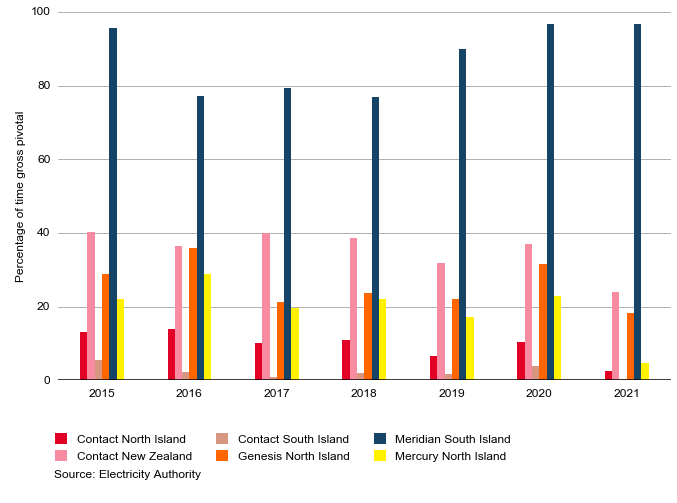

In [20]:
mpl.rcParams['axes.color_cycle'] = [(ea.part['CTCT']),(ea_p['rd2']),(ea_s['rd2']),(ea.part['GENE']),
                                    (ea.part['MERI']),(ea.part['MRPL'])]
                                    #E20027',(ea_p['rd2']),(ea_s['rd2']),'#FF6600','#154467','#959595']

fig = plt.figure(1, figsize=[cm2inch(30),cm2inch(20)])
ax=fig.add_subplot(111)

df1.plot(kind='bar',ax=ax,edgecolor='none')

#ax.set_title('Annual Island Nett pivotal results')
ax.set_ylabel('Percentage of time gross pivotal', fontsize=12)
ax.set_xlabel('year', fontsize=12, family='arial', labelpad=12).set_visible(False)

grid(b=True, which='major', color='k', linestyle='-', axis='y',alpha=0.6, clip_on=True , marker=None )
grid(b=False, axis='x', which='both')
ax.set_axisbelow(True)

ax.set_frame_on(False)

ax.xaxis.tick_bottom()

ax.tick_params(axis='both', which='major', labelsize=12)
ea.plot_formatting(ax=ax)

ax.axhline(y=0, lw=1.5, solid_capstyle='round', marker=None, color='k')#, marker=False, ms=0)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[9] = '2019 (YTD)'
ax.set_xticklabels(labels)

ax.set_ylim(0,100)


leg=ax.legend(fontsize=12, frameon=False, loc=3, bbox_to_anchor=(-0.0125-0.01, -0.27+0.02), 
              handleheight=1, handlelength=1,
              ncol=3)
an1=ax.annotate("Source: Electricity Authority",
           xy=(0.27, 0.1), xycoords='figure fraction',color='k',
            xytext=(.145-0.065
                , .03+0.02), textcoords='figure fraction',
              fontsize=12
          )

savefig('/media/usb/notebooks/Julia/20192020_review/pics/gross_pivotal_results.png', bbox_inches = 'tight', dpi=300)
#savefig('/media/usb/notebooks/Juliaa/Market competition review/pics/gross_pivotal_results_Q1only.png', bbox_inches = 'tight', dpi=300)